In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import pickle
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from toolz.curried import pipe, curry, compose
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

In [3]:
#sample.py
from torchvision import transforms 
from build_vocab import Vocabulary
#train.py
from data_loader import get_loader

In [4]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
#         hiddens = pad_packed_sequence(hiddens, batch_first=True)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)

        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids 

## Notes

 - 9956 words in our vocabulary
 - created a vocab class with word_to_idx and idx_to_word attributes (dicts) using pycocotools
 - a minimum word count threshold of 4 was chosen as default value to identify and remove rare words

# Let's try some model training

###  Define parameters and filepaths

In [6]:
class Args():
    model_path = 'nb_models'
    crop_size = 224
    vocab_path = 'data/vocab.pkl'
    image_dir = 'data/resized2014'
    caption_path = 'data/annotations/captions_train2014.json'
    log_step = 20
    save_step = 1000
    embed_size = 256
    hidden_size = 512
    num_layers = 1
    num_epochs = 5
    batch_size = 256
    num_workers = 4
    learning_rate = 0.001
    cuda = True
args = Args()


if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
    
device = torch.device("cuda:0")

### Image preprocessing, normalization for the pretrained resnet

In [7]:
transform = transforms.Compose([ 
    transforms.RandomCrop(args.crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

### Load vocabulary wrapper

In [8]:
with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print("Size of Vocabulary: %d" % len(vocab))

Size of Vocabulary: 9956


### Build data loader

In [9]:
%%time
data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                         transform, args.batch_size,
                         shuffle=True, num_workers=args.num_workers)

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
CPU times: user 860 ms, sys: 167 ms, total: 1.03 s
Wall time: 1.25 s


### Initialize the models

In [14]:
%%time
encoder = EncoderCNN(args.embed_size).to(device).eval()
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

CPU times: user 1.24 s, sys: 536 ms, total: 1.78 s
Wall time: 1.78 s


### Loss and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=args.learning_rate)

### Train the models


In [12]:
import tqdm

In [16]:
total_step = len(data_loader)
training_losses = []
for epoch in range(args.num_epochs):
    for i, (images, captions, lengths) in enumerate(tqdm.tqdm_notebook(data_loader)):
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs  = decoder(features, captions, lengths)
#         outputs  = pack_padded_sequence(outputs, lengths, batch_first=True)[0]
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % args.log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
            training_losses.append(loss.item())

        # Save the model checkpoints
        if (i+1) % args.save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                args.model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                args.model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

In [5]:
fname = "gen_training.log"
with open(fname, "r") as f:
    lines = f.readlines()

In [12]:
losses = [float(l.split("Loss: ")[-1].split(",")[0]) for l in lines]

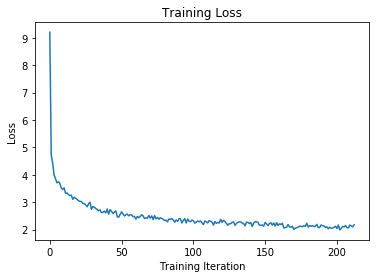

In [15]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.show()